In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [4]:
df = pd.read_csv('data/train.csv')

In [5]:
# сохраняю target в отдельную переменную
df['y'] = df['y'].replace('yes', 1)
df['y'] = df['y'].replace('no', 0)
Y = df['y']

In [6]:
type_obj = [i for i in df.columns if df[i].dtype == 'O']
type_obj

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [7]:
# проверяю на наличие пропусков в df
is_null_dict = df.isna().sum().to_dict()
null_columns = {k:v for k,v in is_null_dict.items() if v > 0}
null_columns

{'age': 588, 'balance': 5, 'month': 5}

In [8]:
# группировка по ID переменных типа object 
job = df.groupby('job')[['ID']].count()
marital = df.groupby('marital')[['ID']].count()
education = df.groupby('education')[['ID']].count()
default = df.groupby('default')[['ID']].count()
housing = df.groupby('housing')[['ID']].count()
loan = df.groupby('loan')[['ID']].count()
contact = df.groupby('contact')[['ID']].count()
poutcome = df.groupby('poutcome')[['ID']].count()
month = df.groupby('month')[['ID']].count()

Числовые переменные в df: ['ID', 'age', 'balance', 'day', 'campaign', 'pdays', 'previous', 'y']


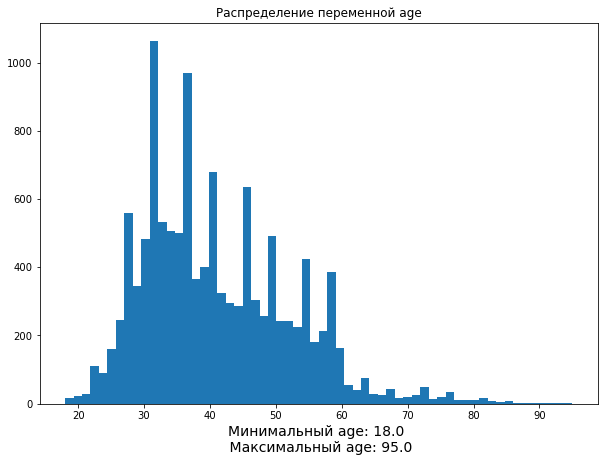

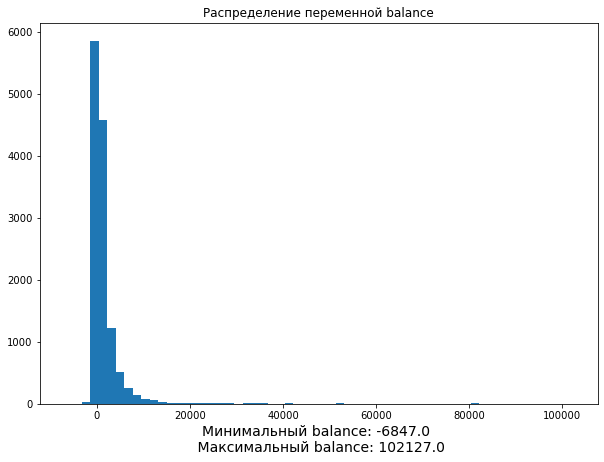

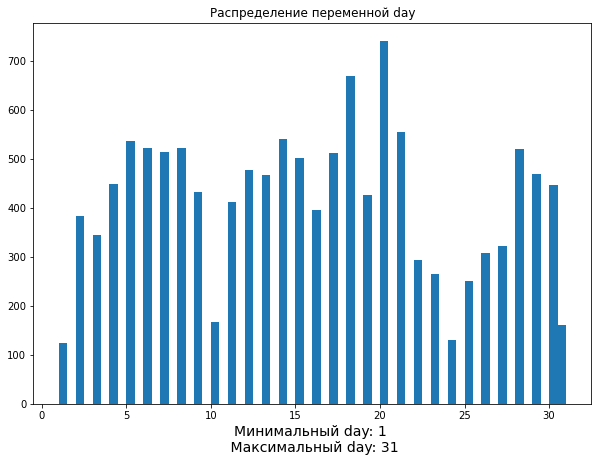

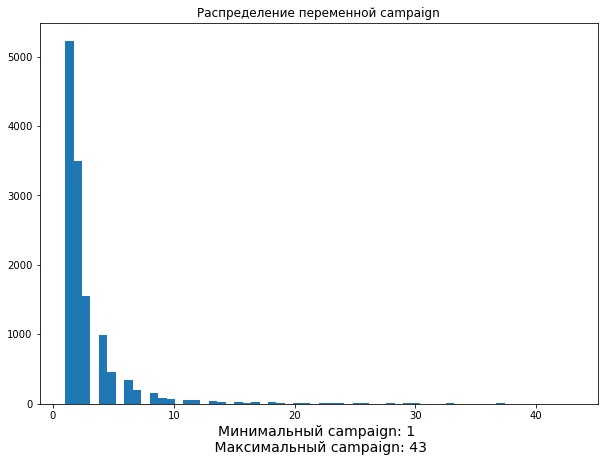

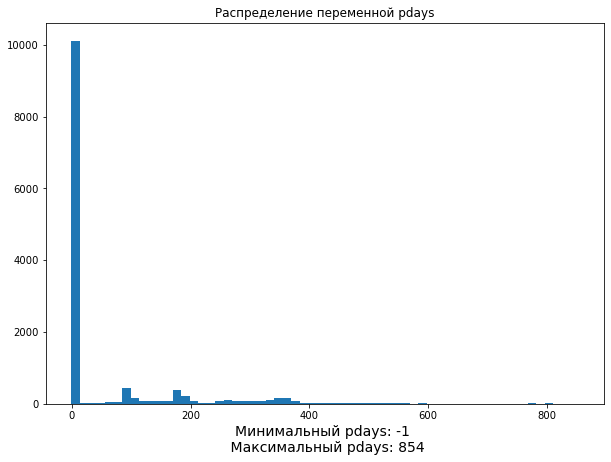

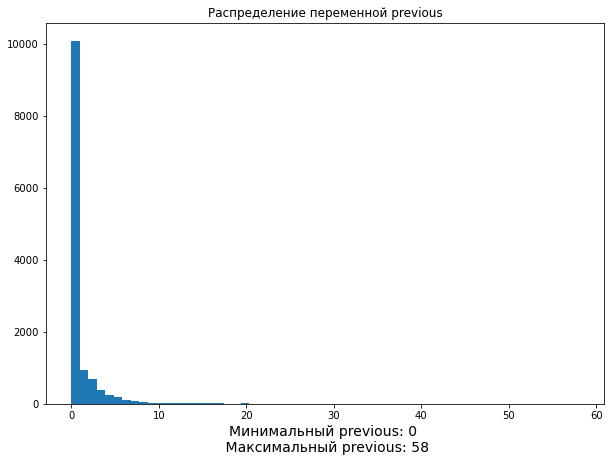

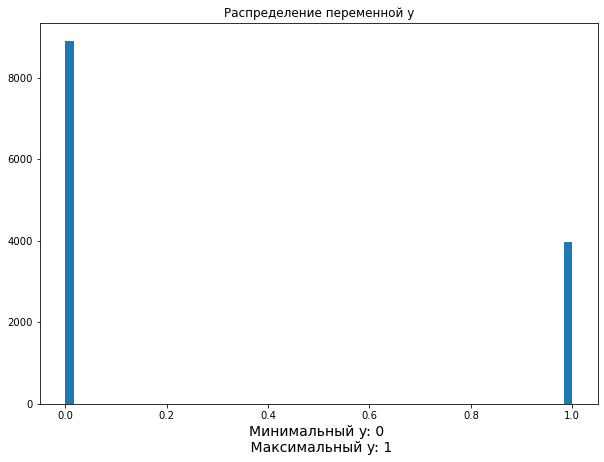

In [9]:
# Распределение числовых переменных
num_obj = [i for i in df.columns if (df[i].dtype == 'int') or (df[i].dtype == 'float')]
print('Числовые переменные в df:', num_obj)
for i in num_obj[1:]:
    plt.figure(figsize=(10, 7))
    plt.title(f'Распределение переменной {i}')
    plt.hist(df[i], bins=60)
    plt.xlabel(f'Минимальный {i}: {df[i].min()} \n Максимальный {i}: {df[i].max()}', fontsize= 14)

In [10]:
# отрицательный баланс в отдельную переменную
df['balance_negative'] = df['balance'][(df['balance'] < 0)]
df['balance_negative'] = df['balance_negative'].fillna(0)

# меняю -1 на 0
df.loc[(df['pdays'] < 0), 'pdays'] = 0

# нормирую переменную баланс
df.loc[(df['balance'] < 0), 'balance'] = 0
df['balance'] = df['balance'][df['balance'] > 0].apply(lambda x: np.log(x))

In [11]:
# группировка по ID переменных типа object 
job = df.groupby('job')[['ID']].count()
marital = df.groupby('marital')[['ID']].count()
education = df.groupby('education')[['ID']].count()
default = df.groupby('default')[['ID']].count()
housing = df.groupby('housing')[['ID']].count()
loan = df.groupby('loan')[['ID']].count()
contact = df.groupby('contact')[['ID']].count()
poutcome = df.groupby('poutcome')[['ID']].count()
month = df.groupby('month')[['ID']].count()

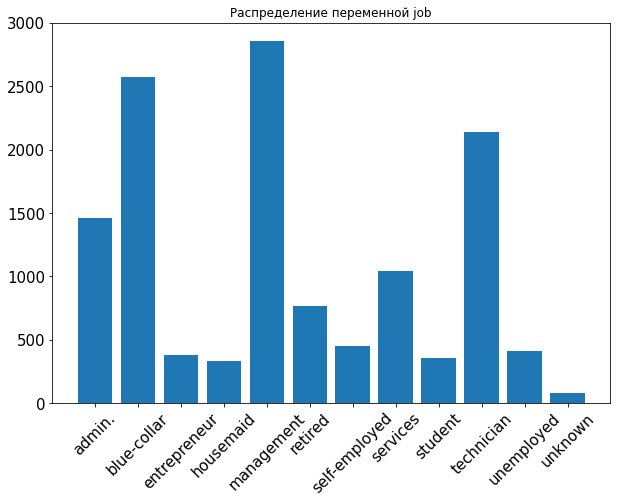

In [12]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной job')
plt.bar(job.index, job["ID"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

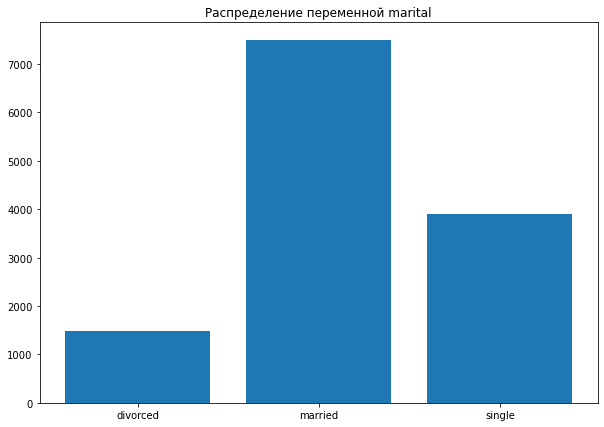

In [13]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной marital')
plt.bar(marital.index, marital["ID"]);

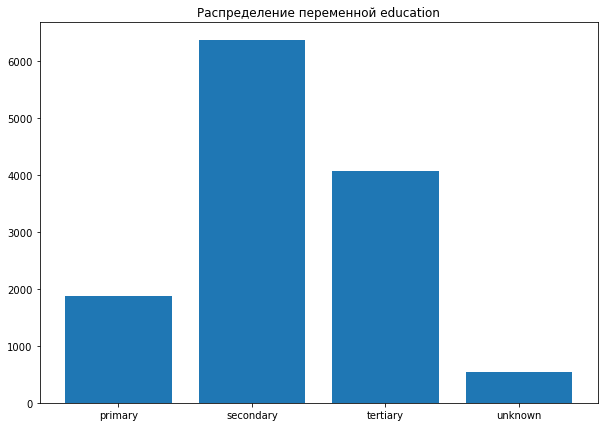

In [14]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной education')
plt.bar(education.index, education["ID"]);

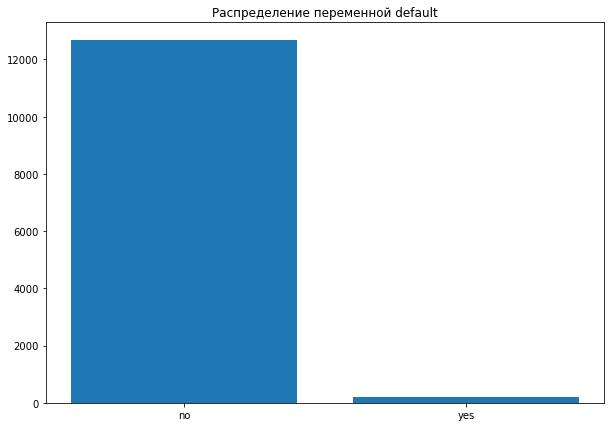

In [15]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной default')
plt.bar(default.index, default["ID"]);

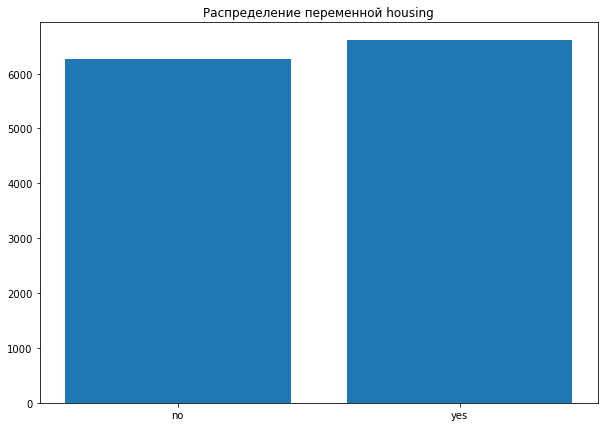

In [16]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной housing')
plt.bar(housing.index, housing["ID"]);

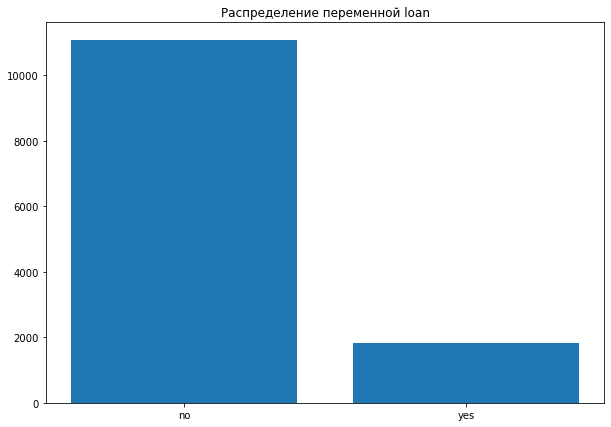

In [17]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной loan')
plt.bar(loan.index, loan["ID"]);

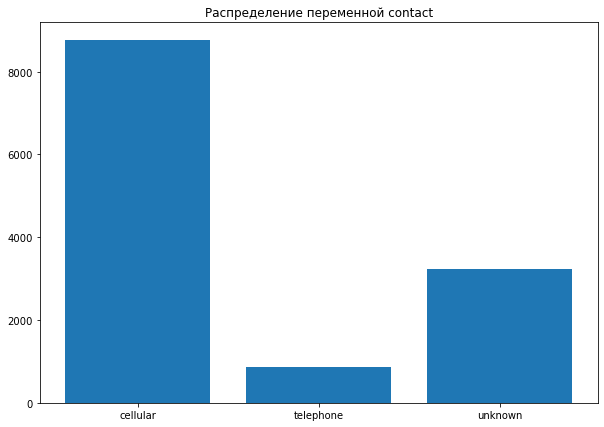

In [18]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной contact')
plt.bar(contact.index, contact["ID"]);

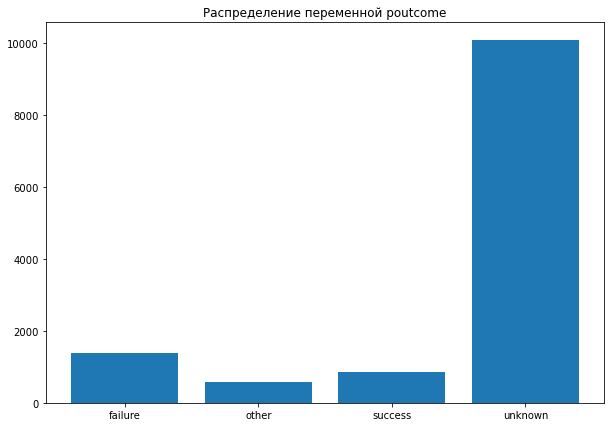

In [19]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной poutcome')
plt.bar(poutcome.index, poutcome["ID"]);

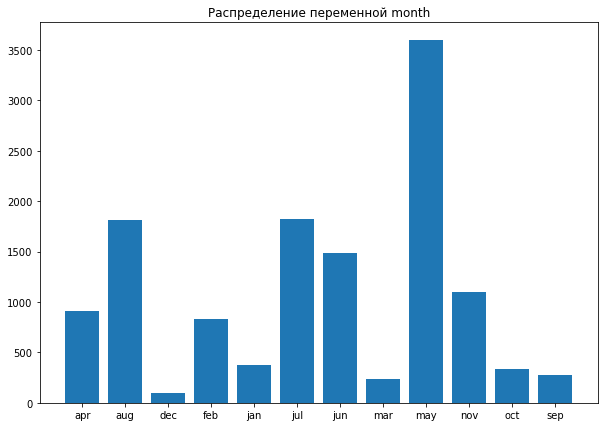

In [20]:
plt.figure(figsize=(10, 7))
plt.title('Распределение переменной month')
plt.bar(month.index, month["ID"]);

In [21]:
# пропущеное значение месяца заменяю на unknown
df['month'] = df['month'].fillna('unknown')

In [22]:
is_null_dict = df.isna().sum().to_dict()
null_columns = {k:v for k, v in is_null_dict.items() if v > 0}
null_columns

{'age': 588, 'balance': 1857}

### Исследование данных

In [23]:
# DataFrame с переменной 'balance' и 'y'
df_balance = pd.DataFrame(df['balance'])
df_for_stat_test = pd.concat((df_balance, Y), axis=1)

# среднее переменной 'balance' сгрупированной по переменной 'y'
df_for_stat_test.groupby('y').mean()

,balance
y,
0,6.291058
1,6.671210


In [24]:
# однофакторный ANOVA тест для выборок с у == 1 и у == 0
from scipy.stats import f_oneway
print(f_oneway(df_for_stat_test[df_for_stat_test['y'] == 1]['balance'], df_for_stat_test[df_for_stat_test['y'] == 0]['balance'].fillna(0)))
# -> различия статистически значимы

F_onewayResult(statistic=nan, pvalue=nan)


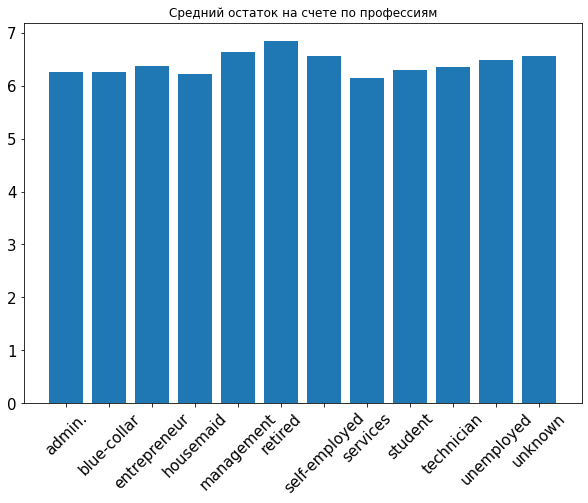

In [25]:
job_balance = df.groupby('job')[['balance']].mean()

plt.figure(figsize=(10, 7))
plt.title('Средний остаток на счете по профессиям')
plt.bar(job_balance.index, job_balance["balance"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

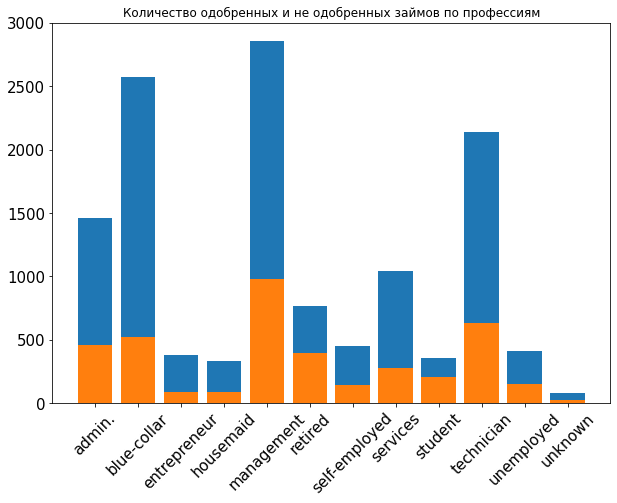

In [26]:
df_y_1 = df[df['y'] == 1] # одобренные займы

job_y = df_y_1.groupby('job')[['y']].count()
job_y1 = df.groupby('job')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных и не одобренных займов по профессиям')
plt.bar(job_y1.index, job_y1["y"])
plt.bar(job_y.index, job_y["y"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

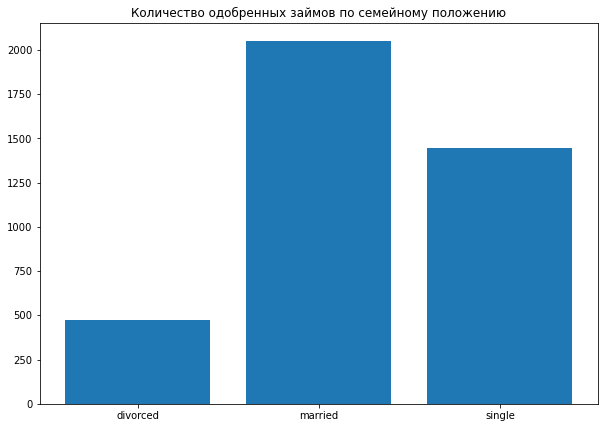

In [27]:
marital_y1 = df_y_1.groupby('marital')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов по семейному положению')
plt.bar(marital_y1.index, marital_y1["y"]);

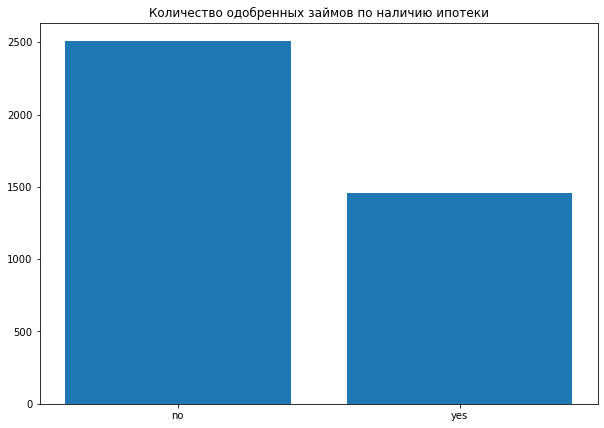

In [28]:
housing_y1 = df_y_1.groupby('housing')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов по наличию ипотеки')
plt.bar(housing_y1.index, housing_y1["y"]);

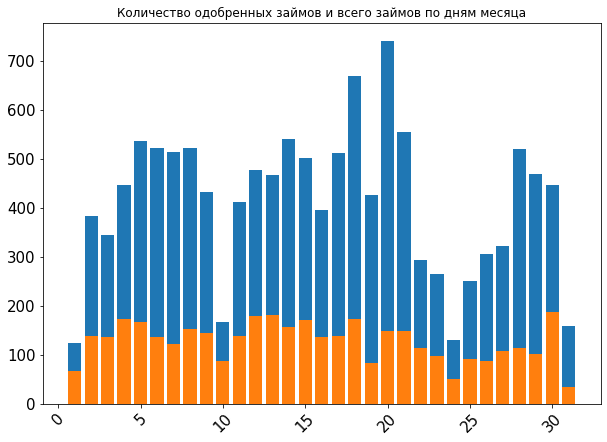

In [29]:
day_ID = df.groupby('day')[['ID']].count()
day_ID1 = df_y_1.groupby('day')[['ID']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов и всего займов по дням месяца')
plt.bar(day_ID.index, day_ID["ID"])
plt.bar(day_ID1.index, day_ID1["ID"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

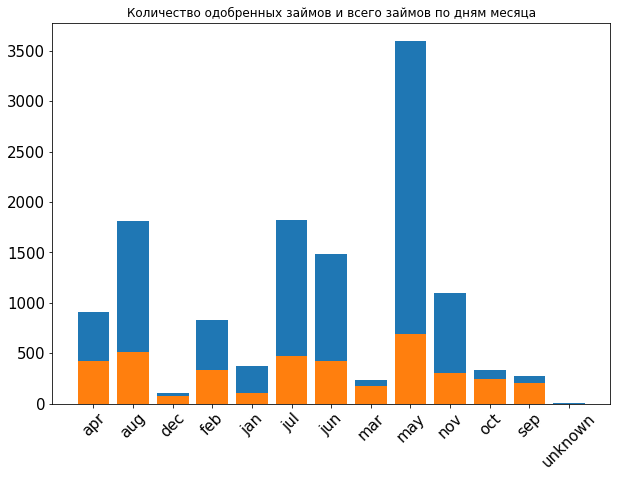

In [30]:
month_ID = df.groupby('month')[['ID']].count()
month_ID1 = df_y_1.groupby('month')[['ID']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество одобренных займов и всего займов по дням месяца')
plt.bar(month_ID.index, month_ID["ID"])
plt.bar(month_ID1.index, month_ID1["ID"])
plt.xticks(rotation=45)
plt.tick_params(labelsize = 15);

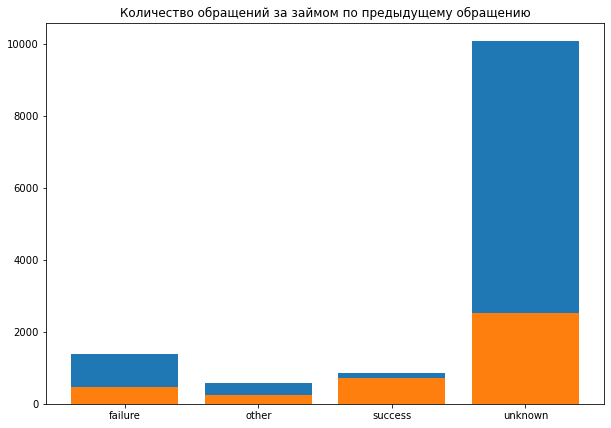

In [31]:
poutcome_y = df.groupby('poutcome')[['y']].count()
poutcome_y1 = df_y_1.groupby('poutcome')[['y']].count()

plt.figure(figsize=(10, 7))
plt.title('Количество обращений за займом по предыдущему обращению')
plt.bar(poutcome_y.index, poutcome_y["y"]);
plt.bar(poutcome_y1.index, poutcome_y1["y"]);

In [44]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier

df_baseline = pd.get_dummies(df, columns = type_obj)

# заполняю пропуски при помощи IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter= 5, random_state= 42)
df_iter_imput_baseline = pd.DataFrame(imp.fit_transform(df_baseline))

# возвращаю названия колонкам после заполнения пропусков 
for dq_c, df_c in zip(df_iter_imput_baseline.columns.to_list(), df_baseline.columns.to_list()):
    df_iter_imput_baseline.rename(columns = {dq_c : df_c}, inplace = True)

# удаляю target из выборки
df_iter_imput_baseline = df_iter_imput_baseline.drop(['y'], axis = 1)

# разбиваю выборку на valid и train
X_train, X_valid, y_train, y_valid = train_test_split(df_iter_imput_baseline, Y, random_state=42)

rfe = RFE(estimator = GradientBoostingClassifier(), n_features_to_select= 20)

rfe.fit(X_train, y_train)
print(f"Train ROC-AUC score: {round(roc_auc_score(rfe.predict(X_train), y_train), 2)}.\nValid ROC-AUC score: {round(roc_auc_score(rfe.predict(X_valid), y_valid), 2)}.")

Train ROC-AUC score: 0.79.
Valid ROC-AUC score: 0.79.


In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'loss': ['log_loss', 'exponential'], 
    'learning_rate':[0.01, 0.05, 0.1],
    'n_estimators': [100, 150, 200],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_depth': [3, 2, 4]
    }
gbc = GradientBoostingClassifier()
gscv = GridSearchCV(gbc, parameters, verbose=False, scoring= 'roc_auc')

gscv.fit(df_iter_imput_baseline, Y)

In [63]:
print(f"Train ROC-AUC score for Grid Search: {round(roc_auc_score(gscv.predict(X_train), y_train), 2)}.\nValid ROC-AUC score for Grid Search: {round(roc_auc_score(gscv.predict(X_valid), y_valid), 2)}.")

Train ROC-AUC score for Grid Search: 0.82.
Valid ROC-AUC score for Grid Search: 0.82.


In [64]:
gscv.best_params_

{'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 150}

In [66]:
gscv.best_score_

0.7923968861236068